In [13]:
#  displays plots directly in this notebook as images
%matplotlib inline
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
import xarray as xr      # matrix and vector containers with labeled axes, used for signals
import holoviews as hv   # a different plotting web-based library mainly for interactive display
import hvplot.xarray     # xaray wrappers for holoviews
import xrscipy           # additional SciPy xarray-compatible wrappers
import xrscipy.signal as dsp    # subpackage convenience: functions for digital signal processing of signals
import xrrandom          # for random sammpling parametrized by xarray objects
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS database

In [3]:
# Code from previous year, sent to us by Miklós

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR
from scipy.stats import f


def compute_granger(x, y, d=2):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    T = len(x)

    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AR(x)
    ar_fit = ar.fit(maxlag=d)
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(maxlags=d)

    # The formula's origin is at Bressler, Granger causality: a well established methodology, NeuroImage (2010),
    F_bressler = (((ar_fit.resid ** 2).sum() - (var_fit.resid[:, 0] ** 2).sum()) / d) \
                 / ((var_fit.resid[:, 0] ** 2).sum() / (T - 2 * d - 1))
    
    p_val = compute_pvals(F_bressler, d, T - 2 * d - 1)

    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0]), p_val, F_bressler

def compute_pvals(F, m1, m2):
    return 1 - f.cdf(F, m1, m2)

def compute_granger_bf(x, y, d=2):

    """Computes back and forth F value for granger causality

        .. math:: F = \log( \sigma_{2}^{2} / \sigma_{1}^{2} )
        
    :param numpy.ndarray x: 1st time series,  array 1D shape
    :param numpy.ndarray y: 2nd time series,  array 1D shape
    :param int d: maxlag for autoregression
    :return: log variance ratios, pvalues, F values : each in x -> y, y -> x order
    :rtype: tuple of float

    """
    h_y2x, p_y2x, Fbress1 = compute_granger(x, y, d)
    h_x2y, p_x2y, Fbress2 = compute_granger(y, x, d)
    
    return h_x2y, h_y2x, p_x2y, p_y2x, Fbress1, Fbress2

(array([2., 4., 4., 5., 7., 4., 6., 1., 1., 1., 0., 0., 1., 0., 1.]),
 array([0.13150001, 0.18486668, 0.23823334, 0.29160001, 0.34496668,
        0.39833335, 0.45170002, 0.50506669, 0.55843336, 0.61180003,
        0.6651667 , 0.71853337, 0.77190004, 0.82526671, 0.87863338,
        0.93200004]),
 <a list of 15 Patch objects>)

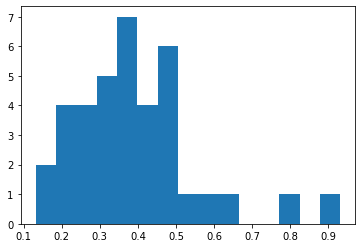

In [15]:
# Load gSPRT data and plot histogram of 
#      dt = t_stop - t_start 
#for every ELM. OBS. It assumes this .mat file exists at this location!
import scipy.io

mat = scipy.io.loadmat('ELM data/17229_Li_ELMs.mat')
plt.hist(np.diff(mat['A']), bins=15)

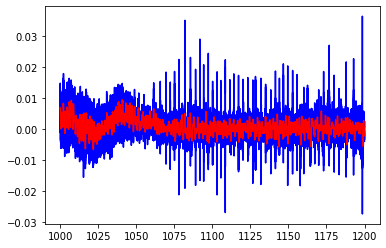

In [34]:
# Load Mirnov coil data (channel 14), select interval (during H-mode)
shot = cdbxr.Shot(18447)
data = shot.Mirnov_A_rad_14_RAW.sel(time=slice(1000, 1200))
x_unfiltered = data.data

# plot unfiltered data
plt.plot(data['time'], x_unfiltered, 'b')

# plot Golay-Savitzky-filtered data (arbitrary parameters!)
x_filtered = savgol_filter(x_unfiltered, 1001, 3)
plt.plot(data['time'], x_filtered, 'r')

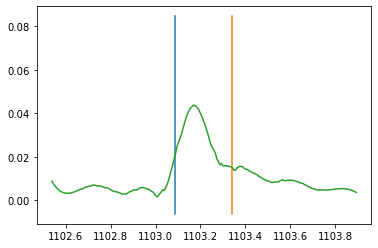

In [36]:
# Look at a specific ELM
shot = cdbxr.Shot(18447)

# interval taken from .mat file, included here in case it doesn't exist
START = 1103.0865144
END = 1103.34251441

# load data in the vicinity of the interval
data = shot['APD.light_profile'][:,14].sel(time=slice(START*.9995, END*1.0005))

# filtering (arbitrary parameters)
x = savgol_filter(data.data, 51, 3)

# plot interval
plt.plot([START, START], [data.min(), data.max()])
plt.plot([END, END], [data.min(), data.max()])

# plot filtered data
plt.plot(data['time'], x)

In [38]:
# tip: use this for curve fitting 
from scipy.optimize import curve_fit

def model(t, A1, A2, t1, t2, C):
    # model function suggested by Jaroslav
    return A1 * np.exp(t/t1) + A2 * np.exp(-t/t2) + C